In [86]:
from analyze_partition_agg import *

### Results Per-Fraud Detector Subsample-and-Aggregate

In [2]:
res_bias = analyze_pda_validation_results_oneshot(stat='aucs', eps=1000., n_noise_draws=50)

In [3]:
# fixing sub_rate, increasing k increases the bias
stats = [c for c in res_bias.columns if 'bias' in c]
df = res_bias.melt(id_vars=['dataset', 'sub_rate', 'k', 'method', 'eps'], value_vars=stats, var_name='algo', value_name='bias')
df['algo'] = ['_'.join(a.split('_')[1:]) for a in df['algo']]
df = df[~df.algo.isin(['agg1', 'agg2', 'agg_max', 'random'])]
df['algo'] = df['algo'].map(ALGORITHM_NAMES)
df.head()

,dataset,sub_rate,k,method,eps,algo,bias
0,amazon_sbm,0.05,20,laplace,1000.0,Clustering Coeff,-0.419004
1,amazon_sbm,0.05,50,laplace,1000.0,Clustering Coeff,-0.423021
2,amazon_sbm,0.05,100,laplace,1000.0,Clustering Coeff,-0.423360
3,amazon_sbm,0.05,200,laplace,1000.0,Clustering Coeff,-0.423421
4,amazon_sbm,0.10,10,laplace,1000.0,Clustering Coeff,-0.403500


In [4]:
def plot_bias_vs_param(plot, datasets, fixed_param_name, fixed_param_value):
    plot = df[(df[fixed_param_name] == fixed_param_value) & (df['dataset'].isin(datasets))].copy()
    plot['abs_bias'] = plot['bias'].abs()

    if fixed_param_name == 'k':
        x_label = 'Fraud Subsample Rate'
        param_name = 'sub_rate'
    if fixed_param_name == 'sub_rate':
        x_label = 'Number of Partitions'
        param_name = 'k'

    markers = ['o', 's', 'v', 'D', '<', 'd', '>']

    g = sns.relplot(data=plot, x=param_name, y='bias', col='dataset', kind='line', col_order=datasets,
                    hue='algo', style='algo', markers=markers, dashes=False, lw=3, markersize=8)

    # add horizontal line at 0 to each subplot  
    for ax in g.axes.flat:
        ax.axhline(0, ls='--', color='black')

    # set subplot titles to just dataset name
    for i, ax in enumerate(g.axes.flat):
        ax.set_title(DATASET_NAMES[datasets[i]], fontsize=16)
        
    g.set_ylabels('Bias of AUC Score', fontsize=16)
    g.set_xlabels(x_label, fontsize=16)

    # increase fontsize of x and y tick labels
    for ax in g.axes.flat:
        ax.tick_params(axis='both', which='major', labelsize=14)

    # move legend outside plot to the botom and split into two rows
    g.figure.legend(title='Fraud Detector', ncols=3, bbox_to_anchor=(0.5, -0.25), loc='lower center', fontsize=12, title_fontsize=14)
    g._legend.set_visible(False)

    plt.tight_layout()
    save_path=f"results/figures/bias_vs_{param_name}_{'_'.join(datasets)}.pdf"
    g.savefig(save_path)
    plt.show()


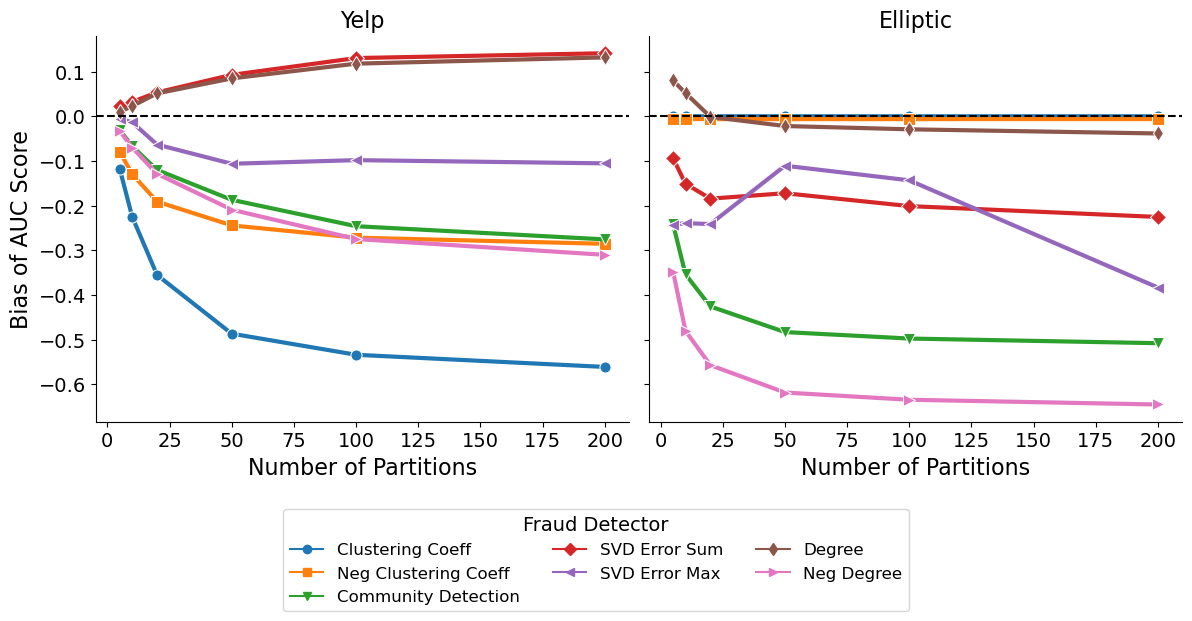

In [5]:
SUB_RATE = 0.25
DATASETS = ['yelp', 'elliptic']
plot_bias_vs_param(df, DATASETS, 'sub_rate', SUB_RATE)

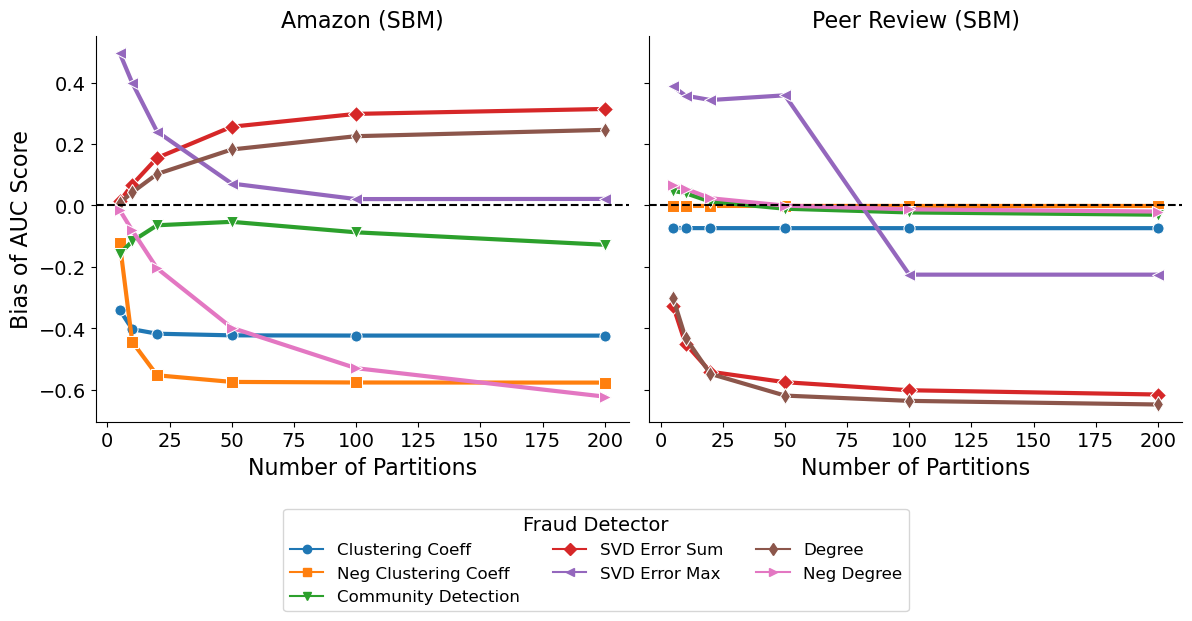

In [6]:
DATASETS = ['amazon_sbm', 'peer_review_sbm']
plot_bias_vs_param(df, DATASETS, 'sub_rate', SUB_RATE)

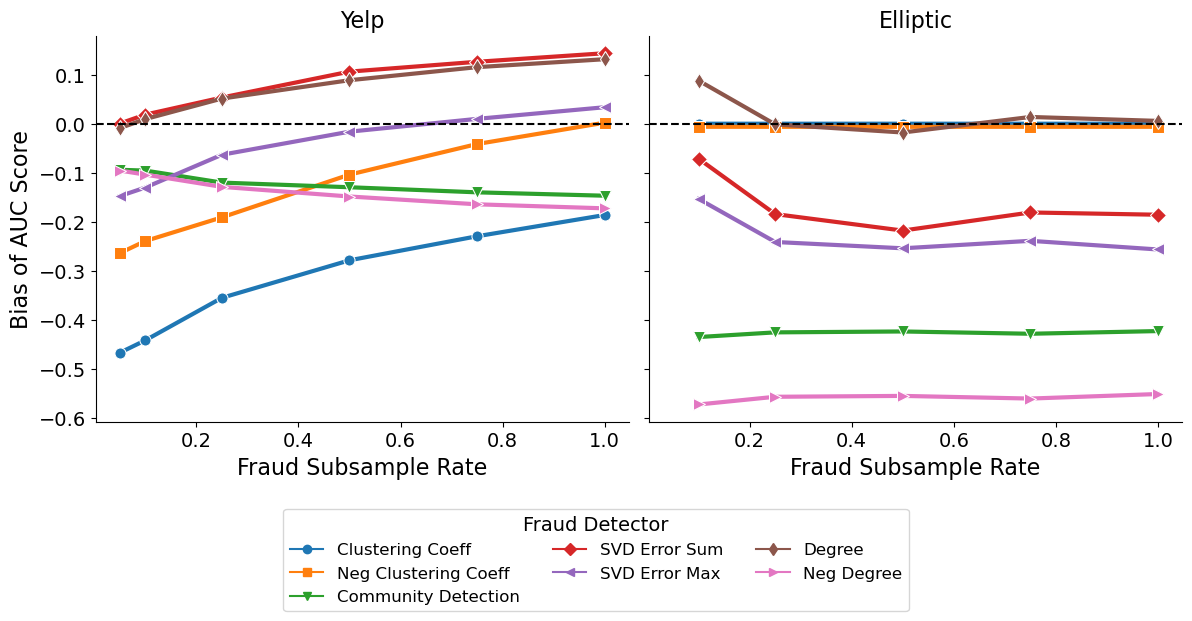

In [7]:
K = 20
DATASETS = ['yelp', 'elliptic']
plot_bias_vs_param(df, DATASETS, 'k', K)

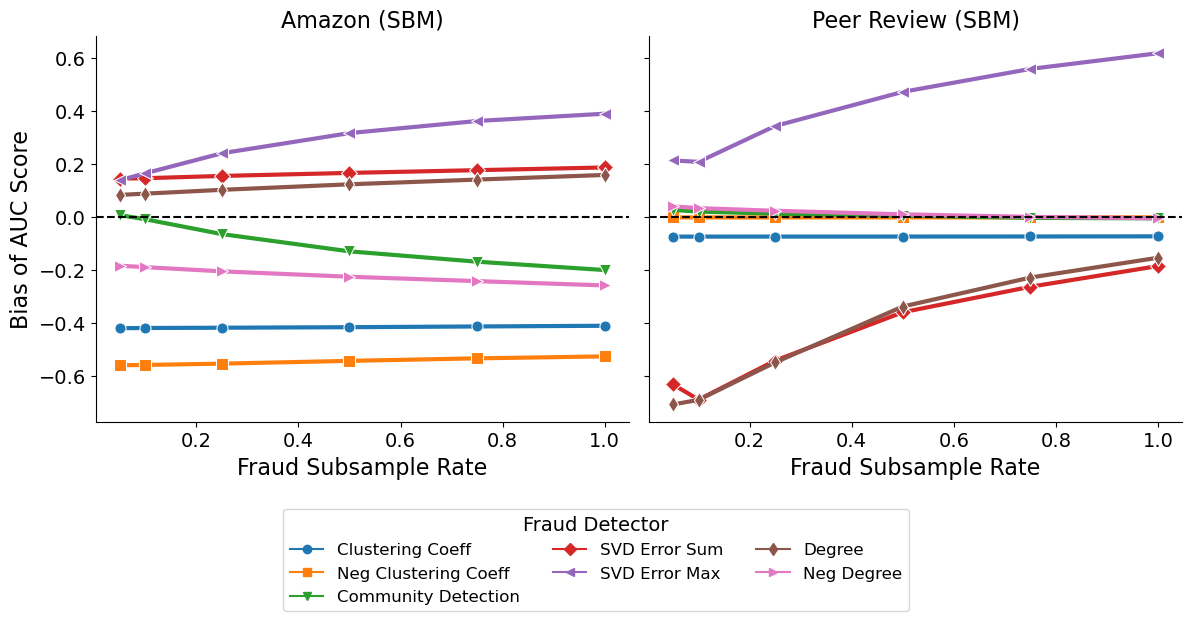

In [8]:
K = 20
DATASETS = ['amazon_sbm', 'peer_review_sbm']
plot_bias_vs_param(df, DATASETS, 'k', K)

## Results for Leaderboard Subsample-and-Aggregate 

In [13]:
df = pd.read_csv('results/pda_validation_results_leaderboard.csv')

In [10]:
random_baselines = get_leaderboard_baselines(split='val')

=== Kendall Tau Baseline for Validation Sets ===
Test vs. Val yelp: 0.0033
Random: 5.2016
Test vs. Val elliptic: 0.021
Random: 5.9705
Test vs. Val amazon_sbm: 0.5359
Random: 8.1351
Test vs. Val peer_review_sbm: 1.1187
Random: 8.6117


In [275]:
def add_hatches(g, n_bars=2):
    # hatches for each bar
    hatches = ['//', '..', 'xx', '++', 'oo', 'O', '||', '\\\\', '|||', '---', '///', '+++']
    hatches = hatches[:n_bars]

    # iterate through each subplot / Facet
    for ax in g.axes.flat:
        # select the correct patches
        patches = [patch for patch in ax.patches]

        # the number of patches should be evenly divisible by the number of hatches
        h = [[hatch]*(len(patches) // n_bars) for hatch in hatches]
        h = [item for sublist in h for item in sublist]
        # iterate through the patches for each subplot
        for patch, hatch in zip(patches, h):
            patch.set_hatch(hatch)
            fc = patch.get_facecolor()
            patch.set_edgecolor(fc)
            patch.set_facecolor('none')

    return hatches


def plot_k_vs_kendalltau(df, sub_rate, datasets, eps, random_baselines):
    df = df[df['sub_rate'] == sub_rate]

    max_eps = df.eps.max()
    df = df[df.eps.isin([max_eps, eps])]
    df['eps'] = df['eps'].astype(str)

    # get results with no noise
    g = sns.catplot(data=df, x='k', y='dist', col='dataset', kind='bar',
                     col_order=datasets,hue='eps', errorbar=("ci", 95), capsize=0.05, errwidth=1.5, palette='colorblind', hue_order=[str(max_eps), str(eps)])       
    
    # set subplot titles to just dataset name
    for i, ax in enumerate(g.axes.flat):
        ax.axhline(random_baselines[datasets[i]], ls='--', color='black') # add line for random baseline
        ax.set_title(DATASET_NAMES[datasets[i]], fontsize=16) # set title to just dataset name
        ax.tick_params(axis='both', which='major', labelsize=14) # increase fontsize of x and y tick labels
    
    _ = add_hatches(g)
        
    g.set_ylabels('Weighted Kendall-Tau Distance', fontsize=16)
    g.set_xlabels('Number of Partitions (k)', fontsize=16)      

    handles, _ = g.axes.flat[0].get_legend_handles_labels()
    g._legend.remove()
    l = g.figure.legend(handles, ['No Noise', f'Laplace Noise ($\epsilon$={int(eps/10.) if eps >= 10. else round(eps/10., 1)})'], ncol=2, loc='lower center', 
                bbox_to_anchor=(0.5, -0.1), frameon=False, fontsize=16)

    plt.tight_layout()

    save_path=f"results/figures/kendall_tau_nonoise_vs_{eps}_{'_'.join(datasets)}.pdf"
    g.savefig(save_path)

    plt.show()

In [276]:
SUB_RATE = 0.25
DATASETS = ['yelp', 'elliptic']

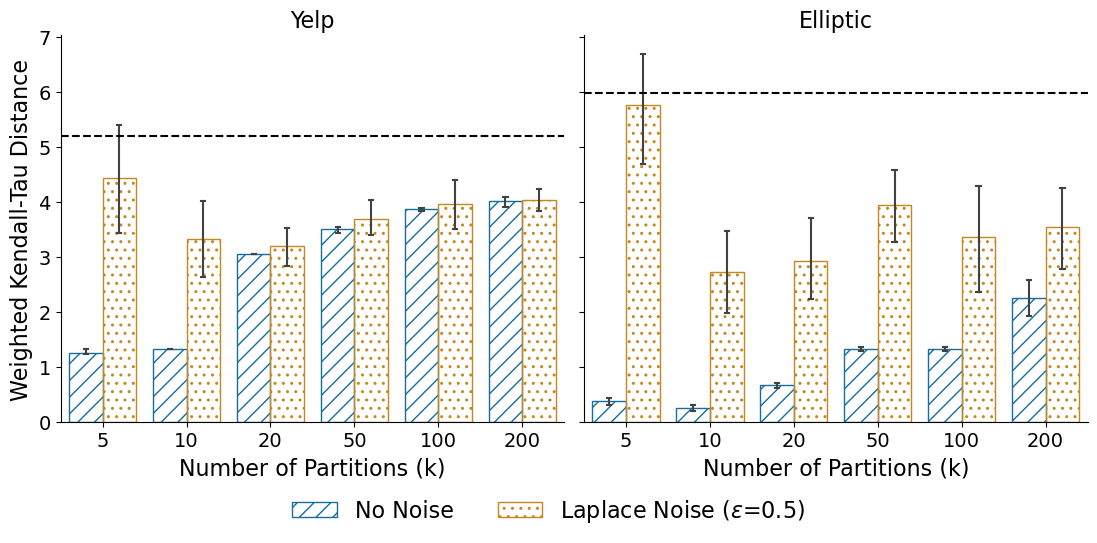

In [277]:
plot_k_vs_kendalltau(df, SUB_RATE, DATASETS, 5., random_baselines)

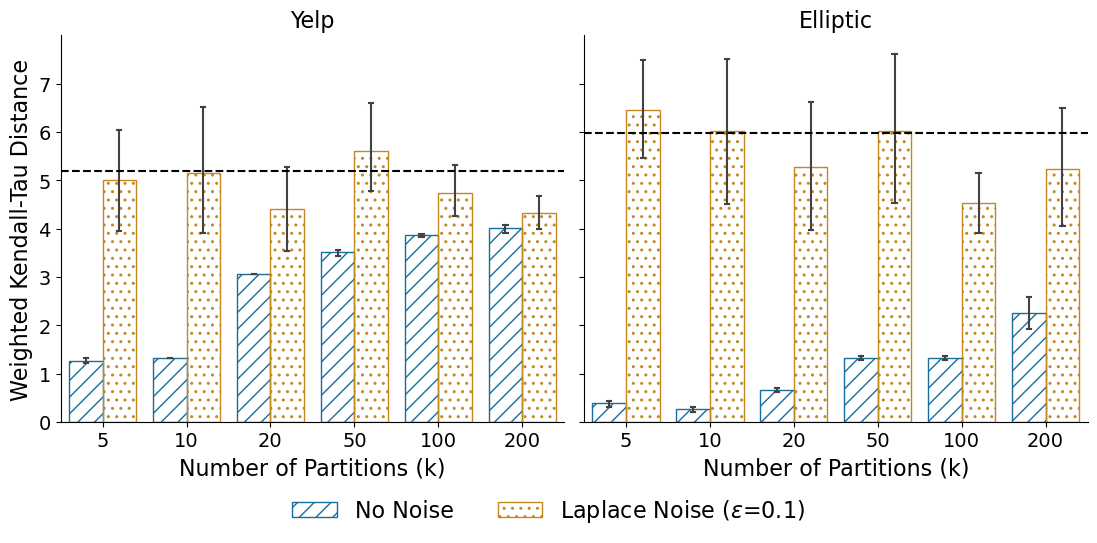

In [278]:
plot_k_vs_kendalltau(df, SUB_RATE, DATASETS, 1., random_baselines)

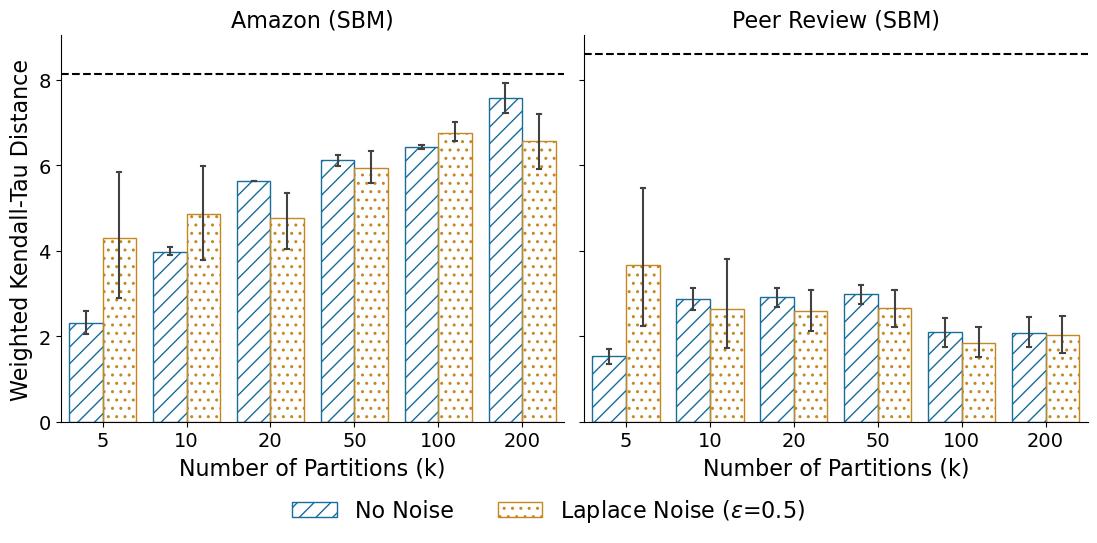

In [281]:
SUB_RATE = 0.5

DATASETS = ['amazon_sbm', 'peer_review_sbm']
plot_k_vs_kendalltau(df, SUB_RATE, DATASETS, 5., random_baselines)

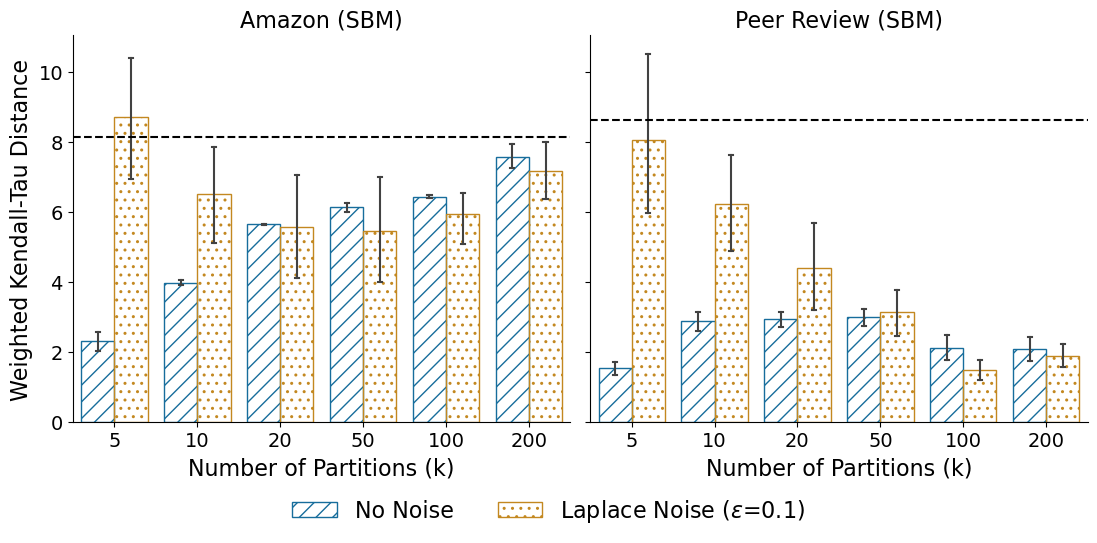

In [282]:
DATASETS = ['amazon_sbm', 'peer_review_sbm']
plot_k_vs_kendalltau(df, SUB_RATE, DATASETS, 1., random_baselines)